# Setting Irrigation Lines

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import Functions as fun
import seaborn as sns
sns.set_context("paper",font_scale=2)

Let's plot the map again (from last notebook) and the first emitters line in our irrigation system:

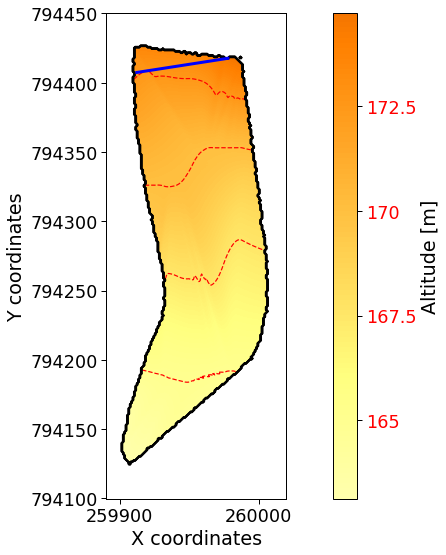

In [12]:
fun.plot_map()
# A 66 meters row in the top of the map according to govmap
line_0 = np.array([[259912.2193, 794407.3171],
                   [259977.9211, 794417.5103]]) 
plt.plot(line_0[:,0],line_0[:,1],lw=3,c='blue')

## Calculating a Line Bellow

Next, we define a function that calculates the two points of a new line that its distance from a line ('line' argument) is r ('r' as argument) row. Note that each row is 6 meters spaced.

Note the we want the line will be in the following way. The distance vector from the starting point on the new line is perpendicular to the 'line' vector (You can see the next figure in order to understand the idea).

The function is according to:


Let's call to the first two points of 'line' argument $P_0 = (x_1, y_1)$ and $P_1 = (x_2, y_2)$

Let's consider
* $(a,b)$ the starting point (from the west) of the next line bellow 'line'
* $m = \frac{y_2 - y_1}{x_2 - x_1}$ the coordinate slope of 'line'
* $D$, the row distance, in our case is 6 meters.

There are two conditions for $(a,b)$:
* $\frac{y_1 - b}{x_1 - a} = - \frac{1}{m}$
* $(y_1 - b)^2 + (x_1 - a)^2 = D^2$

The solution is:

$b = \pm y_1 - \sqrt{\frac{D^2}{1+m^2}}$

$a = x_1 - m(b-y_1)$

And to calculate the end point of the line that starts are $(a,b)$, we can do the same thing only this time using $P_1 = (x_2, y_2)$.

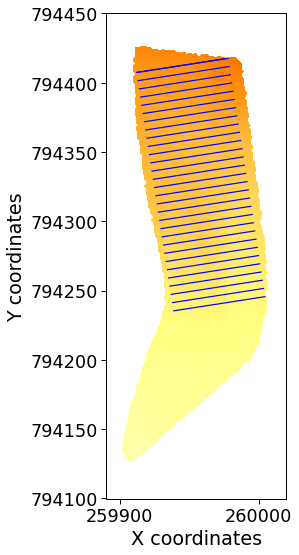

In [13]:
def calculate_distance(line):
    return np.sqrt(np.sum((line[1] - line[0]) ** 2))

def calculate_coor_slope(line):
    return (line[1][1] - line[0][1])/(line[1][0] - line[0][0])

def calculate_line_point_from(r,line):
    result = np.array([])
    for i in [0,1]:
        x1 = line[i][0]
        y1 = line[i][1]
        D = 6 * r
        m = calculate_coor_slope(line_0)
        b = y1 - np.sqrt(D ** 2 / (1 + m ** 2))
        a = x1 - m * (b - y1)
        result = np.append(result, np.array([a,b]))
    return result.reshape(2,2)

fun.plot_map(False,False)
line_0 = np.array([[259912.2193, 794407.3171],
                   [259977.9211, 794417.5103]]) # A 66 meters row in the top of the map
plt.plot(line_0[:,0],line_0[:,1],c='blue')
plt.grid(b=False)

for r in np.arange(0,30,1):
    line_r = calculate_line_point_from(r,line_0)
    plt.plot(line_r[:,0],line_r[:,1],c='blue')

It's easy to see that after 30 rows we need to change the direction. After trials and errors we got the next lines that consists our irrigation emitters lines:

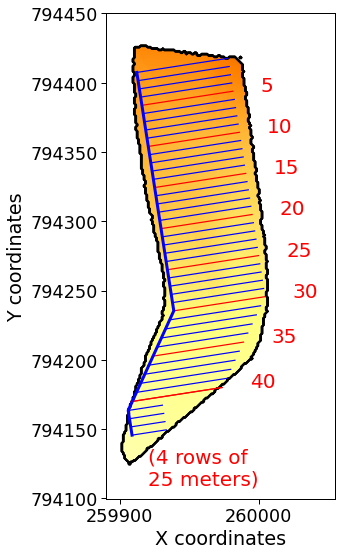

In [14]:
fun.plot_map(False,True)
plt.grid(b=False)
m = calculate_coor_slope(line_0) # the coordinate slope for all lines
main_line = []
lines = []

# For the first 40 rows
for r in np.arange(0,40,1):
    line = calculate_line_point_from(r,line_0)
    if r < 30: # No shifting if it's one of the first 30 rows
        x_shift = 0
    if r >= 30: # Shifting if it's one of the 30-40 rows
        x_shift = (r-29) * 4
        
    y_shift = x_shift * m
    line = line - np.array([[x_shift,y_shift],[x_shift,y_shift]])
    
    # Plotting
    if r == 39:
        plt.plot(line[:,0],line[:,1],c='red')
    if (r + 1) % 5 == 0: 
        plt.text(line[1,0]+20,line[1,1],str(r+1),c='red',fontsize=20)
        plt.plot(line[:,0],line[:,1],c='red')
    else:
        plt.plot(line[:,0],line[:,1],c='blue')
    
    # Appeding points for main line
    if r in [0,29]:
        main_line.append(line[0])
    lines.append(line.flatten())
    
# Different code for the last small 4 rows
line_39 = lines[-1].reshape(2,2)
for r in np.arange(1,5,1):
    line = calculate_line_point_from(r,line_39)
    m = calculate_coor_slope(line_39)
    x_shift = 3
    y_shift = x_shift * m
    line = line - np.array([[x_shift,y_shift],[x_shift,y_shift]])
    line[1] = line[1] - np.array([[41,41*m]])
    plt.plot(line[:,0],line[:,1],c='blue')
    if r in [1,4]: # Appeding points for main line
        main_line.append(line[0])
    lines.append(line.flatten())
    

plt.xlim(259890, 260055)
plt.text(259920,794110,'(4 rows of\n25 meters)',c='red',fontsize=20)
main_line = np.array(main_line)
plt.plot(main_line[:,0],main_line[:,1],c='blue',lw=3)

# Saving everything for next notebooks
plt.savefig('Figures/IrrigationSystemMap',bbox_inches='tight')
np.save('LinesData/lines', lines)
np.save('LinesData/main_line', main_line)

Let's calculate the main line distance (according the main line points we appended through the code):

In [15]:
main_line_dis = 0
for i in range(0,len(main_line) - 1):
    main_line_dis = main_line_dis + calculate_distance(main_line[i:i+2])
main_line_dis

271.0538073270221

We can see that the main pipe has 3 different sections. Let's calculate the space between connection points to the drip lines per each on this sections:

In [16]:
# Calculating two adjacent random connection points from first section
calculate_distance(np.vstack((lines[4][:2],lines[5][:2])))

6.000000000009905

In [17]:
# Calculating two adjacent random connection points from second section
calculate_distance(np.vstack((lines[34][:2],lines[35][:2])))

7.237755974424044

In [18]:
# Calculating two adjacent random connection points from third section
calculate_distance(np.vstack((lines[41][:2],lines[42][:2])))

6.000000000009905

As we can see, we need to remember that the space for the second section the space is much bigger than 6 meters. We will use it for the final sketch.

# Altitude Profile

The next code plot all of the drip lines profiles

C:\Users\User8\AppData\Local\Temp/ipykernel_8296/3083170628.py:18: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(15,4))


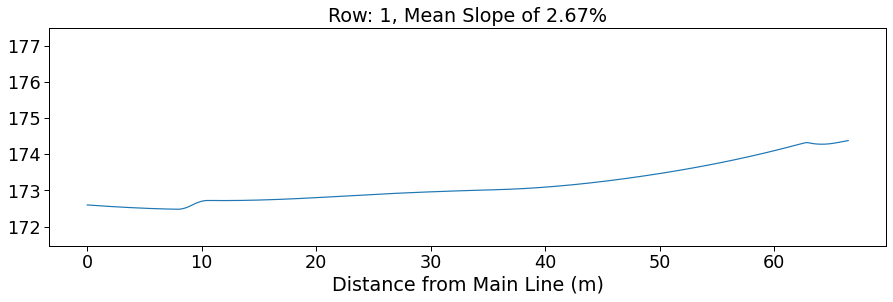

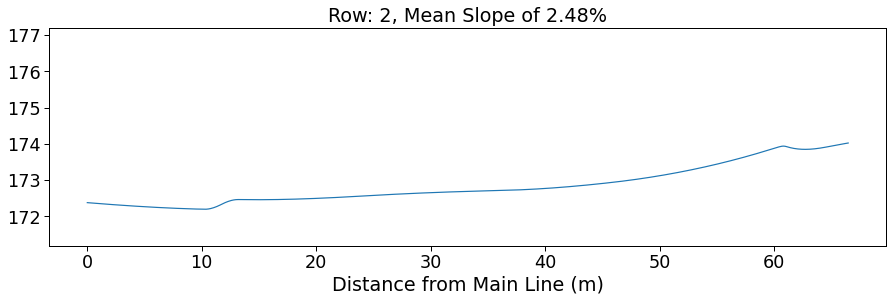

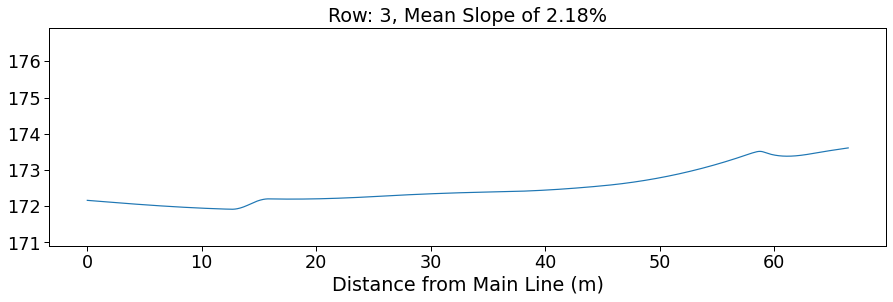

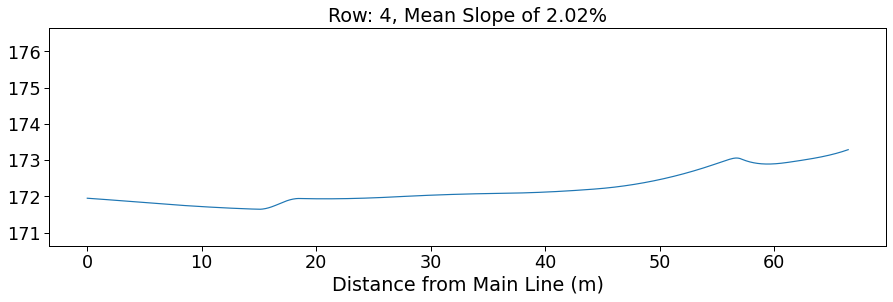

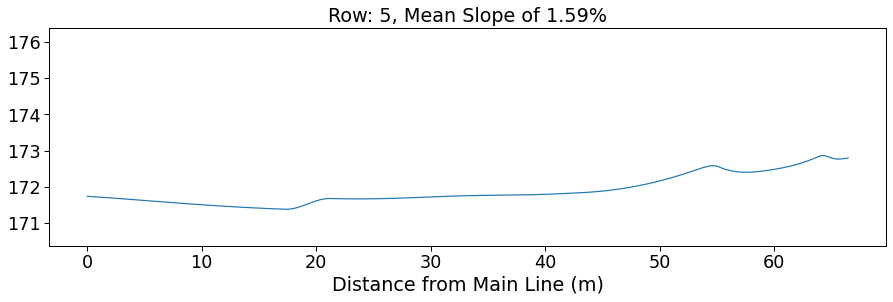

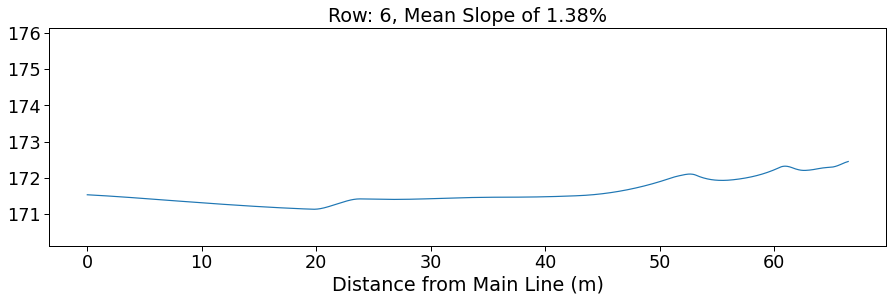

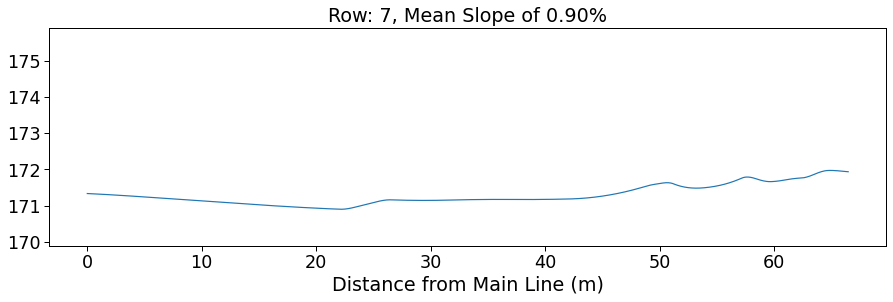

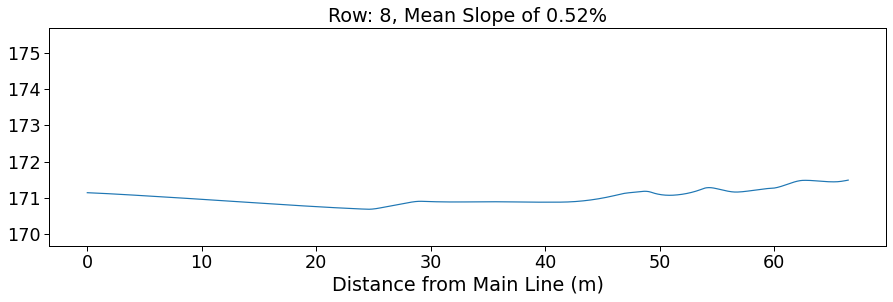

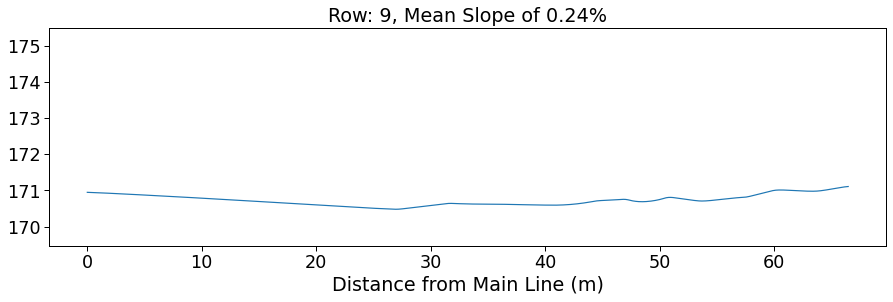

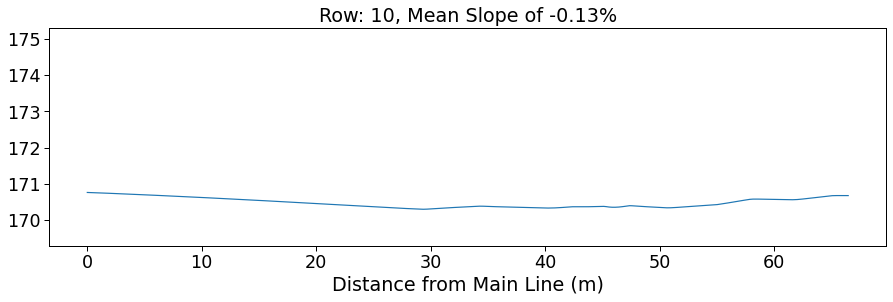

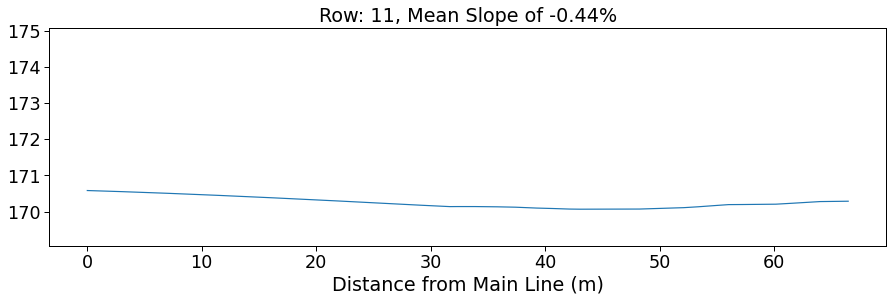

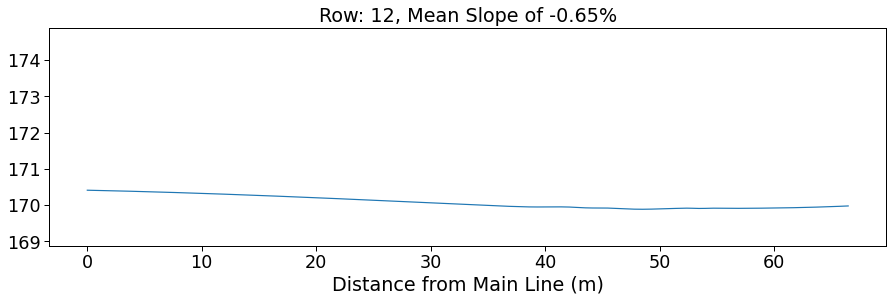

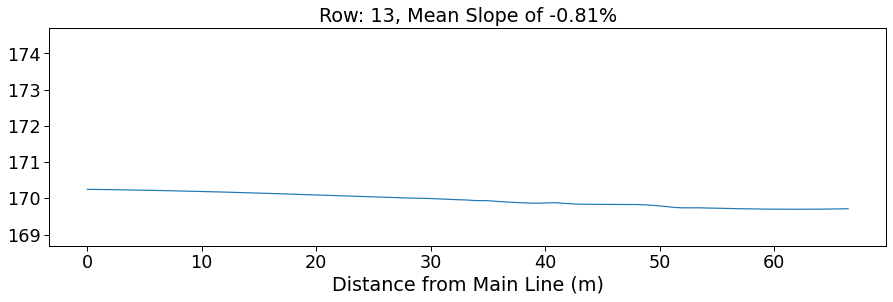

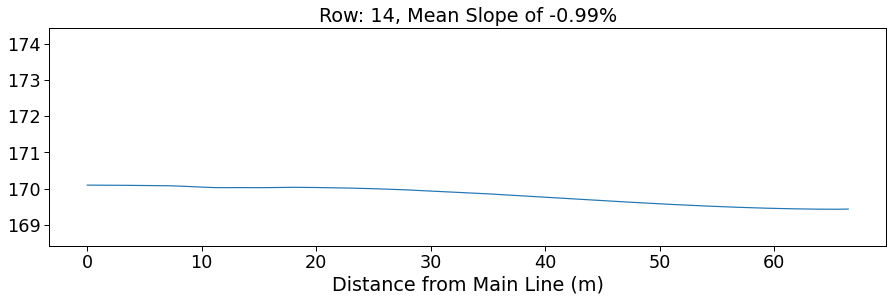

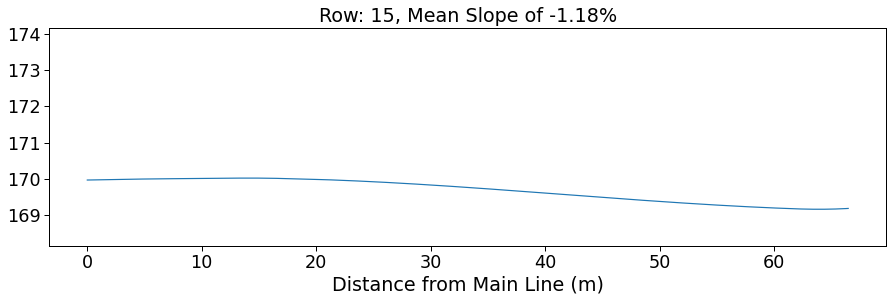

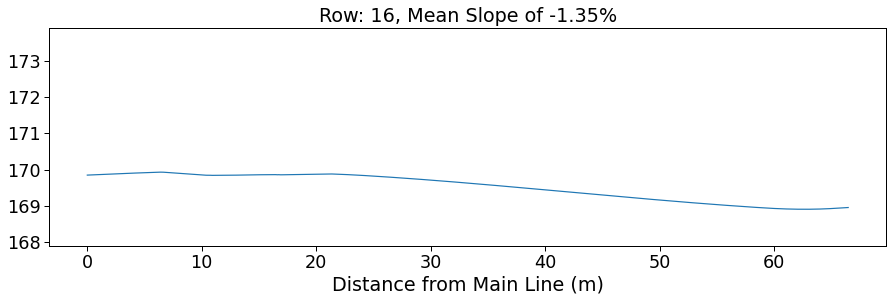

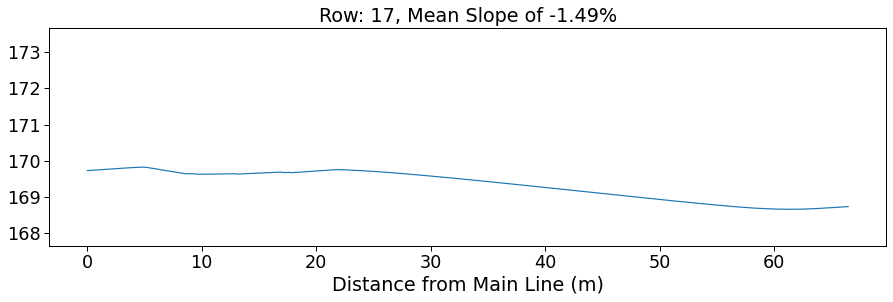

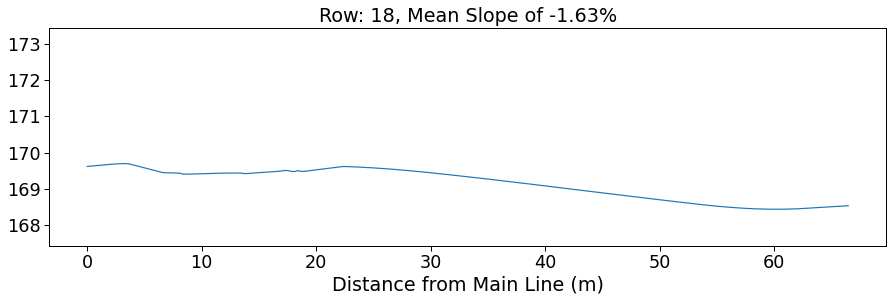

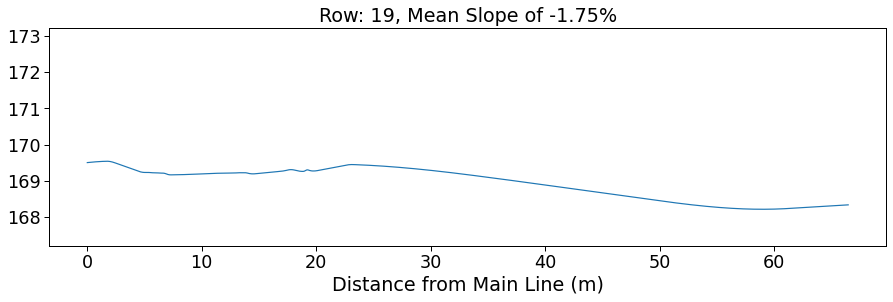

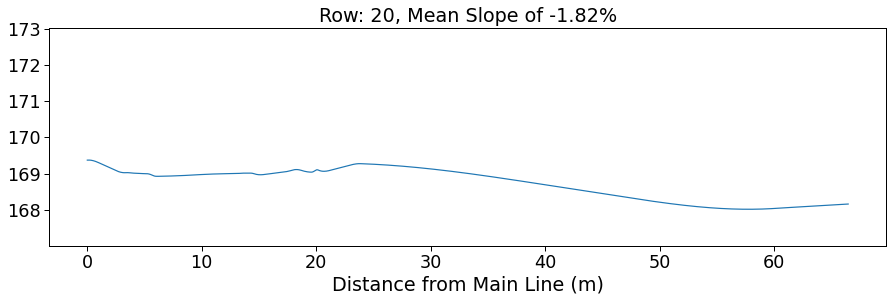

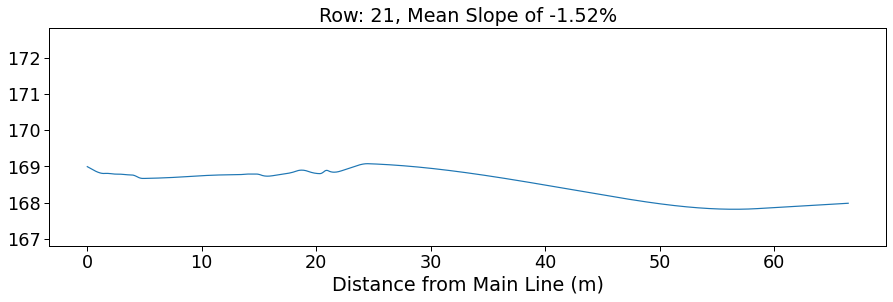

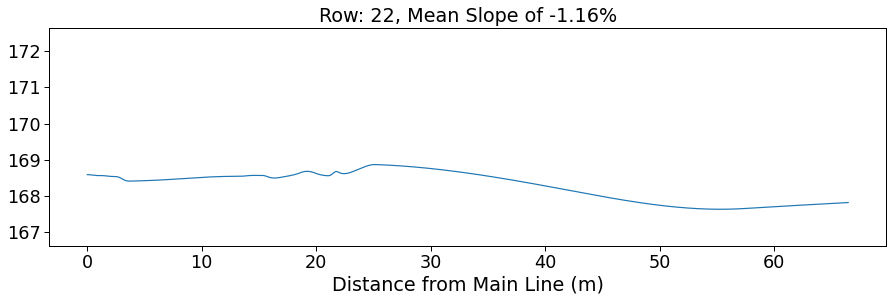

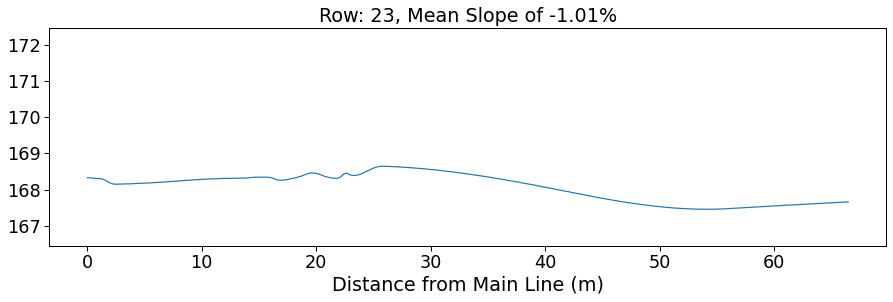

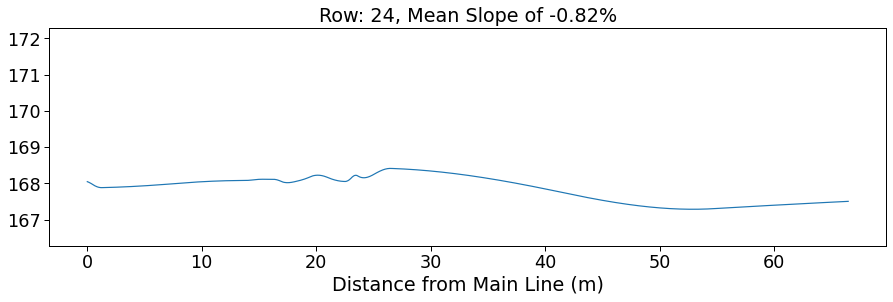

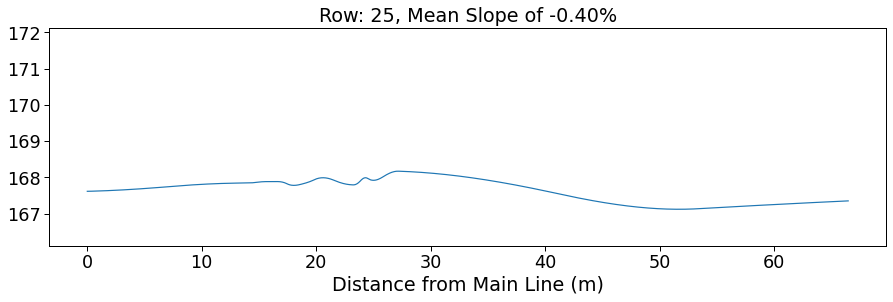

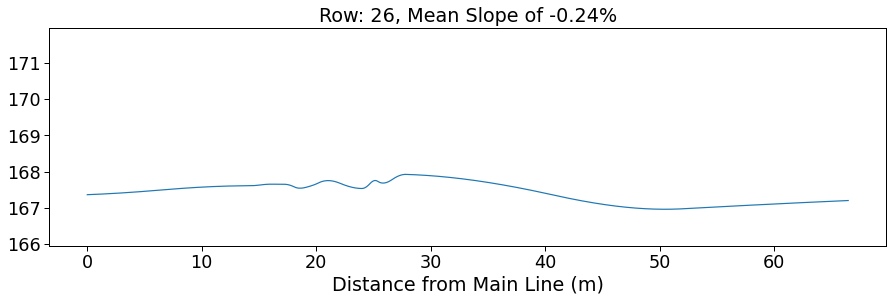

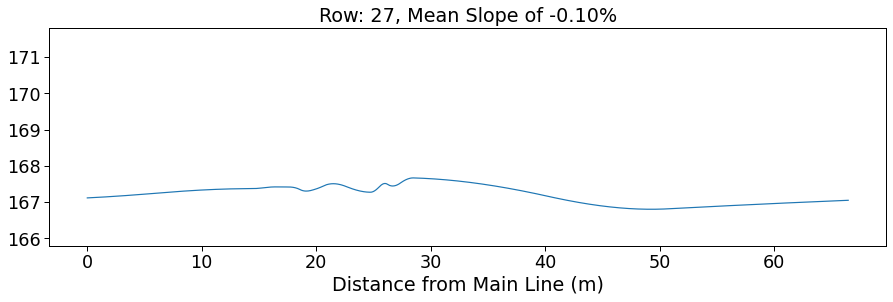

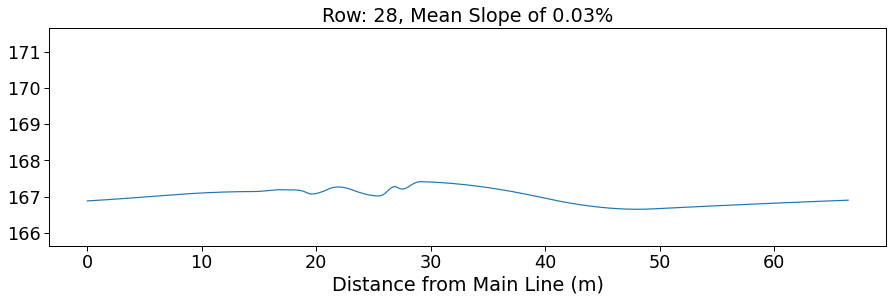

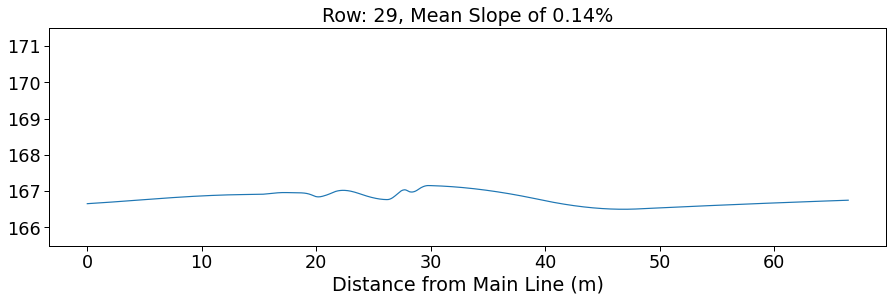

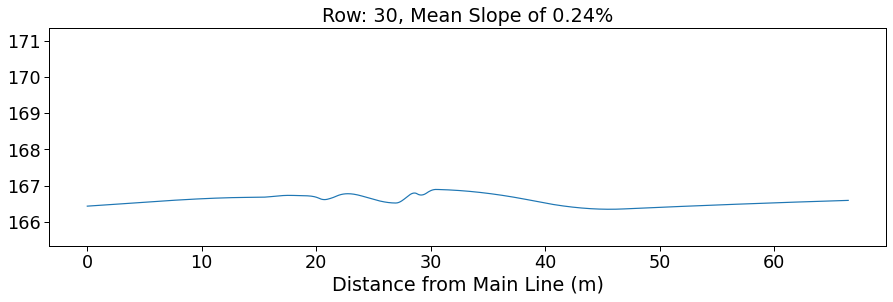

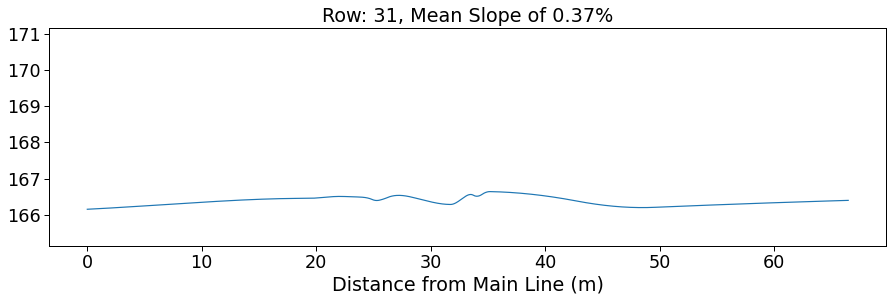

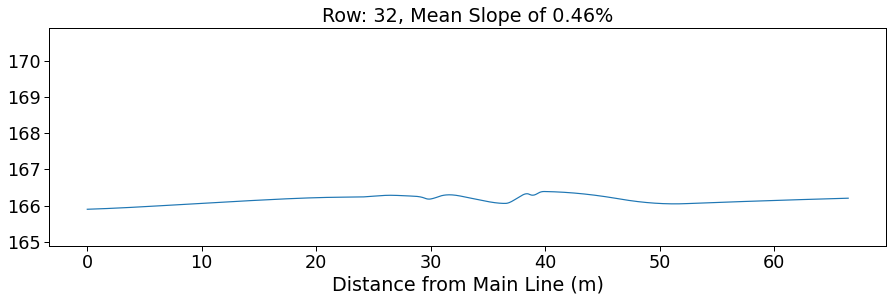

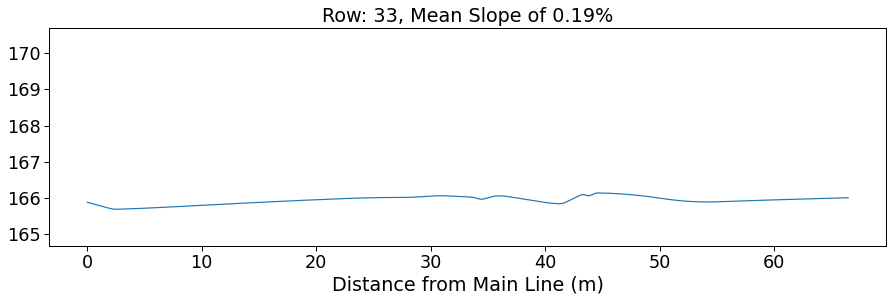

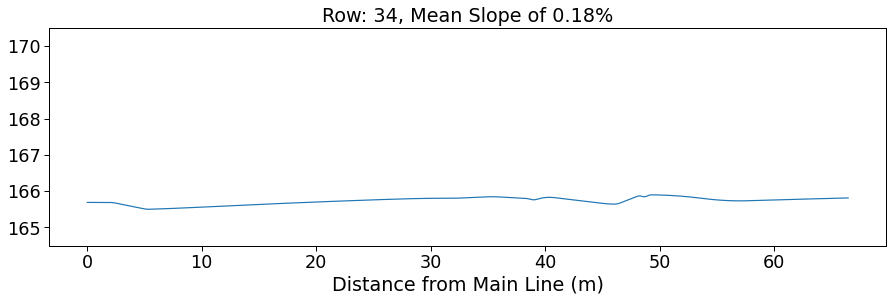

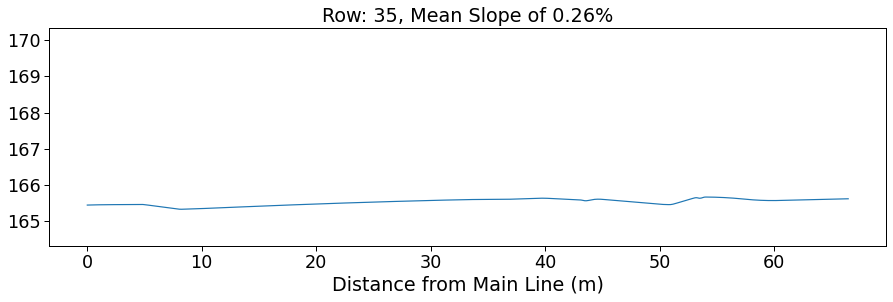

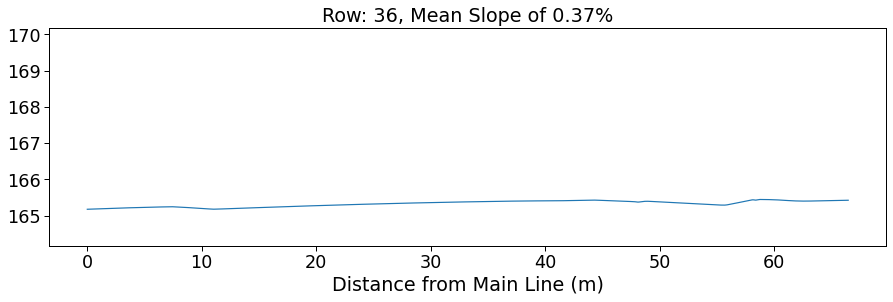

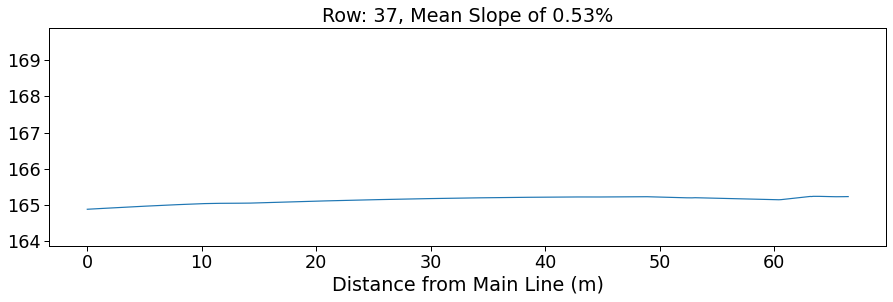

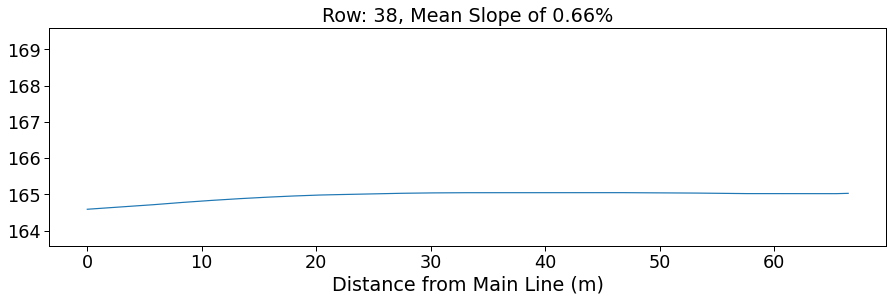

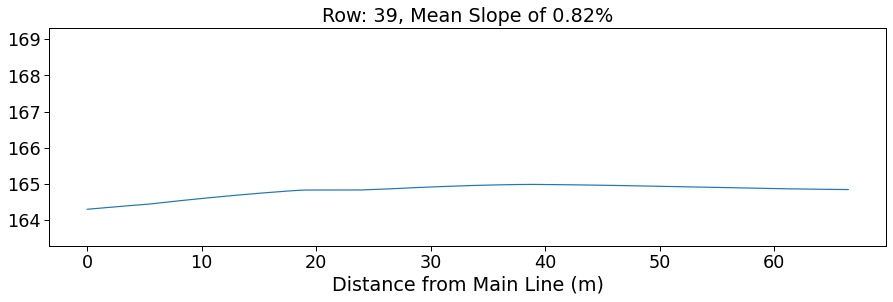

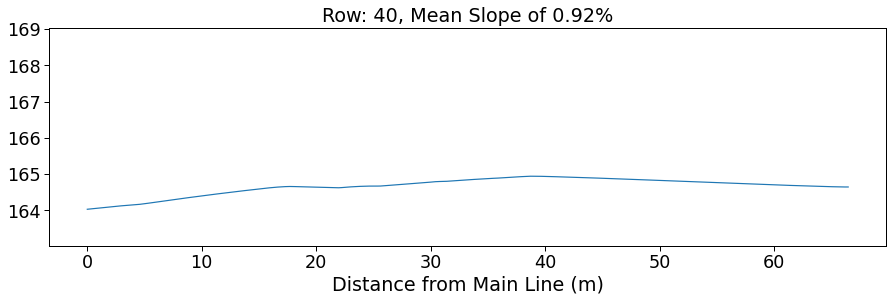

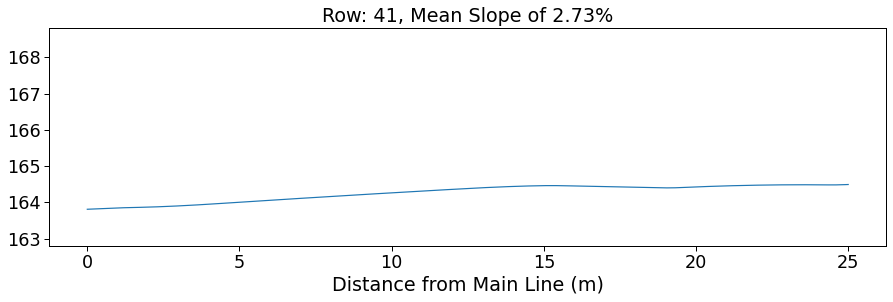

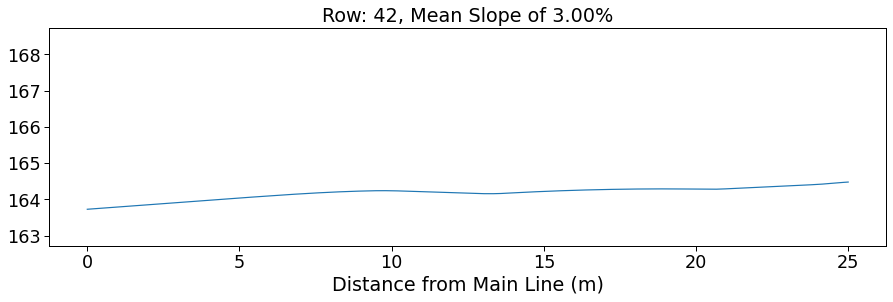

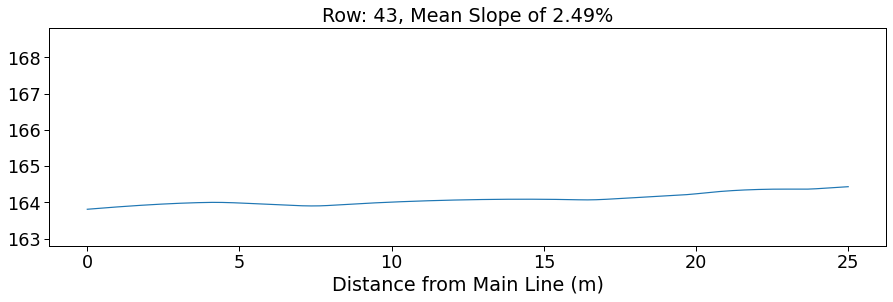

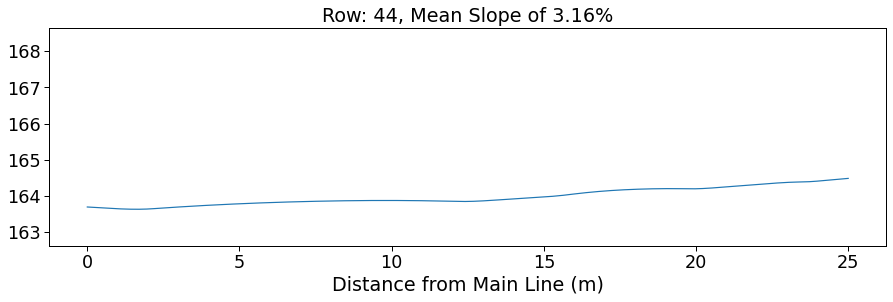

In [19]:
# Plotting the altitude profile for a line
def plot_profile(line, r='?'):
    x_line = np.linspace(line[0,0],line[1,0],1000)
    y_line = np.linspace(line[0,1],line[1,1],1000)
    xy_line = np.c_[x_line, y_line]
    L = calculate_distance(line)
    x = np.linspace(0,L,1000) # The distance from main line
    altitude = fun.interpolate_altitude(xy_line).flatten()
    slope = (altitude[1:] - altitude[:-1]) / (x[1:] - x[:-1]) * 100 # [%]
    mean_slop = np.mean(slope) # [%]
    plt.plot(x,altitude )
    plt.title('Row: {}, Mean Slope of {:.2f}%'.format(r,mean_slop))
    plt.xlabel('Distance from Main Line (m)')
    plt.ylim(min(altitude)-1,5+min(altitude))
    
for line,r in zip(lines,range(0,len(lines))):
    line = line.reshape(2,2)
    plt.figure(figsize=(15,4))
    plot_profile(line,r+1)

# NOTE

For the next notebooks, we save this plotting code as a function in the file functions.py